In [19]:
## library
import random
import numpy as np
import torch
from torch.autograd.variable import Variable
from torch import nn, optim
import argparse
import matplotlib as plt 
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import sys
import visdom
import numpy as np
from keras.utils.vis_utils import plot_model
import time
from tqdm import tqdm
import tensorflow as tf
from torchsummary import summary
from torch.utils.data import Subset
import tensorflow as tf
import cv2
import numpy as np
from PIL import Image

##Classifier_cifar pytorch    

In [2]:
noise_dim=100
batch_size=60
num_img_channel=3
img_size=32
sample_interval=64          



In [153]:
class Classifier_cifar(nn.Module):
    def __init__(self):
        super(Classifier_cifar,self).__init__()

        
        
        self.conv_layer1=nn.Sequential(
            nn.Conv2d(num_img_channel,3,kernel_size=[7,7],stride=1,padding=2,bias =False,dilation=1),
        
            
            nn.LeakyReLU(0.18,inplace=True),
        )

        self.conv_layer2=nn.Sequential(
            nn.Conv2d(3,16,kernel_size=[6,6],stride=1,padding=0,bias =False,dilation=1,),
        
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.18,inplace=True),
        )
        


        self.fc_block1= nn.Sequential(
            
            nn.Linear(16*25*25,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.18,inplace=True),
            nn.Linear(512,10)
        )



    def forward(self,img):
        layer1_out=self.conv_layer1(img)
        layer2_out=self.conv_layer2(layer1_out)
        conv_out=layer2_out.view(img.size(0),16*25*25)
        l2_value = self.fc_block1(conv_out)
        l2_value2 = l2_value.unsqueeze_(dim=2).unsqueeze_(dim=3)
        return l2_value2

In [4]:

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)



In [5]:

Tensor = torch.cuda.FloatTensor
# Téléchargement des données CIFAR-10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train_vis,x_test_vis=(x_train,x_test)
(x_train, y_train), (x_test, y_test)= (torch.tensor(x_train),torch.tensor(y_train).cuda()), (torch.tensor(x_test),torch.tensor( y_test).cuda())
# Affichage des dimensions des ensembles d'entraînement et de test
print('Dimensions des ensembles d\'entraînement :')
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('Dimensions des ensembles de test :')
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)
x_train=x_train.permute(0,3,1,2).cuda().float()
x_test=x_test.permute(0,3,1,2).cuda().float()




Dimensions des ensembles d'entraînement :
x_train: torch.Size([50000, 32, 32, 3])
y_train: torch.Size([50000, 1])
Dimensions des ensembles de test :
x_test: torch.Size([10000, 32, 32, 3])
y_test: torch.Size([10000, 1])


In [84]:

classifier_cifar=Classifier_cifar()
classifier_cifar=classifier_cifar.cuda()

classifier_cifar.apply(weights_init_normal)
def Class_out(K):
    if classifier_cifar(x_test)[K].argmax()==0:
        print("C'est un Avion!")
    if classifier_cifar(x_test)[K].argmax()==1:
        print("C'est une Voiture!")
    if classifier_cifar(x_test)[K].argmax()==2:
        print("C'est un Oiseau!")
    if classifier_cifar(x_test)[K].argmax()==3:
        print("C'est un chat!")
    if classifier_cifar(x_test)[K].argmax()==4:
        print("C'est un Cerf!")
    if classifier_cifar(x_test)[K].argmax()==5:
        print("C'est un Chien!")
    if classifier_cifar(x_test)[K].argmax()==6:
        print("C'est une Grenouille!")
    if classifier_cifar(x_test)[K].argmax()==7:
        print("C'est un Cheval!")
    if classifier_cifar(x_test)[K].argmax()==8:
        print("C'est un Bateau!")
    if classifier_cifar(x_test)[K].argmax()==9:
        print("C'est un Camion!")

In [85]:

Image_conv1=classifier_cifar.conv_layer1(x_test[0,:,:,:].unsqueeze(0))
Image_conv2=classifier_cifar.conv_layer2(Image_conv1)

[Image_conv1.shape,Image_conv2.shape]

[torch.Size([1, 3, 30, 30]), torch.Size([1, 16, 25, 25])]

In [88]:
classifier_cifar(x_test[:13,:,:,:]).shape


torch.Size([13, 10, 1, 1])

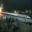

In [89]:
Image.fromarray(np.uint8(x_test_vis[1001]))

In [90]:
K=random.randint(0,10000)
Image_vis=x_test[K,:,:,:].unsqueeze(0)
Image_vis_conv1=classifier_cifar.conv_layer1(Image_vis)
Image_vis_conv2=classifier_cifar.conv_layer2(Image_vis_conv1)


In [92]:


Image_vis_conv1=classifier_cifar.conv_layer1(Image_vis)
Image_vis_conv2=classifier_cifar.conv_layer2(Image_vis_conv1)

Image_vis_conv1=Image_vis_conv1.cpu().detach().numpy()
Image_vis_conv2=Image_vis_conv2.cpu().detach().numpy()
Image_vis_conv1=np.transpose(Image_vis_conv1,(0,2,3,1))
Image_vis_conv2=np.transpose(Image_vis_conv2,(0,2,3,1))

Image_vis_conv1=Image_vis_conv1.squeeze(0)
Image_vis_conv2=Image_vis_conv2.squeeze(0)

# Créez une image à partir du tableau NumPy
Image.fromarray(np.uint8(Image_vis_conv2))





TypeError: Cannot handle this data type: (1, 1, 16), |u1

In [93]:
lr=0.0001
b1=0.5
b2=0.999
optimizer=optim.Adam(classifier_cifar.parameters(),lr=lr,betas=(b1,b2))
loss_C=nn.CrossEntropyLoss()

indice=np.arange(50000)



In [94]:
from tqdm import tqdm

def train(n_epochs):
    for epoch in tqdm(range(n_epochs)):
        print('Epoch {}'.format(epoch))
        shuffled_indices=np.random.permutation(indice)
        x_train_shuffled=x_train[shuffled_indices,:,:,:]
        y_train_shuffled=y_train[shuffled_indices]
        for i in range(int(len(x_train)/batch_size)):
            imgs= x_train_shuffled[i*batch_size:(i+1)*batch_size,:,:,:]
            
        
            labels = y_train_shuffled[i*batch_size:(i+1)*batch_size]
            optimizer.zero_grad()

            output = classifier_cifar(imgs)

            loss = loss_C(output, labels.unsqueeze(1).long() )

            loss.backward()
            optimizer.step()


In [130]:
train(1)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0


100%|██████████| 1/1 [00:03<00:00,  3.45s/it]


In [27]:
torch.argmax(classifier_cifar(x_test),dim=1)


tensor([[[3]],

        [[9]],

        [[8]],

        ...,

        [[3]],

        [[5]],

        [[7]]], device='cuda:0')

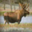

In [141]:
K=random.randint(0,10000)
Image.fromarray(np.uint8(x_test_vis[K]))

In [147]:

Image_vis=x_test[K,:,:,:].unsqueeze(0)
Image_vis_conv1=classifier_cifar.conv_layer1(Image_vis)
Image_vis_conv2=classifier_cifar.conv_layer2(Image_vis_conv1)

Image_vis_conv1=Image_vis_conv1.cpu().detach().numpy()
Image_vis_conv2=Image_vis_conv2.cpu().detach().numpy()

Image_vis_conv1=np.transpose(Image_vis_conv1,(0,2,3,1))
Image_vis_conv2=np.transpose(Image_vis_conv2,(0,2,3,1))

Image_vis_conv1=Image_vis_conv1.squeeze(0)
Image_vis_conv2=Image_vis_conv2.squeeze(0)

# Créez une image à partir du tableau NumPy




Image.fromarray(np.uint8(Image_vis_conv1))

C'est un Oiseau!


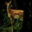

In [148]:

Class_out(K)

Image.fromarray(np.uint8(x_test_vis[K]))

In [152]:
Image.fromarray(np.uint8(Image_vis_conv2[0]))

In [143]:

accuracy=(torch.sum(torch.argmax(classifier_cifar(x_test),dim=1).squeeze(1)==y_test))*100/10000
print('Précision moyenne=', np.array((accuracy.float().cpu())),"%")


Précision moyenne= 59.25 %
